In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats

from sklearn import linear_model
import statsmodels.formula.api as smf

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

sns.set_style("white")

In [2]:
crime_feats = pd.read_csv('crime_features.csv')
crime_feats.head()

,city,population,Pop Squared,Robbery,Murder,Propertycrime
0,Adams Village,1861.000,3463321.000,0,0,12.000
1,Addison Town and Village,2577.000,6640929.000,0,0,24.000
2,Akron Village,2846.000,8099716.000,0,0,16.000
3,Albany,97956.000,9595377936.000,1,1,4090.000
4,Albion Village,6388.000,40806544.000,1,0,223.000


In [3]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = crime_feats['Propertycrime'].values.reshape(-1, 1)
X = crime_feats[['population', 'Robbery', 'Murder']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[1.87083296e-02 8.13468586e+01 2.04243871e+02]]

Intercept: 
 [-38.20311954]

R-squared:
0.708591603045696


With population, poulation squared, robbery and murder this model explains 84.4% of variance in property crimes. From the coefficients it seems that property crime has the biggest per occurance increase when there are more murders.

## Check Assumptions

### Assumption One: Linear Relationship

Scatterplots

/Users/research/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


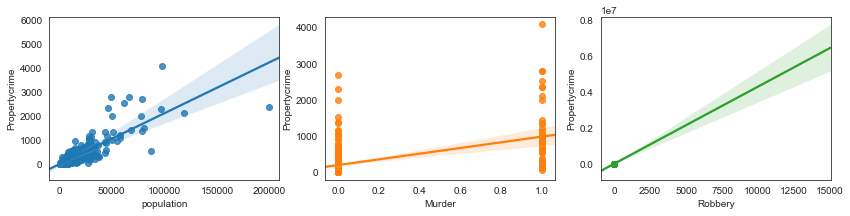

In [4]:
# Set variables
X_plot = ['population', 'Murder', 'Robbery']
Y_plot = 'Propertycrime'

# Define the scatterplot function
def plot_scat(frame, X, Y):
    fig, axes = plt.subplots(1, len(X), figsize=(14,3))
    for var in X:
        idx = X.index(var)
        sns.regplot(y=frame[Y], x=frame[var], ax=axes[idx])

plot_scat(crime_feats, X_plot, Y_plot)

### Assumption two: multivariate normality

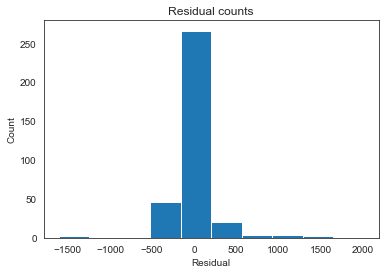

In [5]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = crime_feats['Propertycrime']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

In [6]:
# Windosirze to remove extreme outliers
crime_feats['population_wins'] = scipy.stats.mstats.winsorize(crime_feats['population'], limits= 0.05)

The residual counts seem to have an outlier

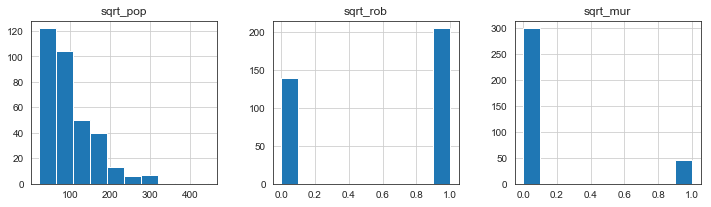

In [7]:
pop_feat = crime_feats['population']
rob_feat = crime_feats['Robbery']
mur_feat = crime_feats['Murder']

# Create a feature using a non-linear transformation.
crime_feats['sqrt_pop'] = [math.sqrt(x) for x in  pop_feat]
crime_feats['sqrt_rob'] = [math.sqrt(x) for x in  rob_feat]
crime_feats['sqrt_mur'] = [math.sqrt(x) for x in  mur_feat]

# Define the histogram plotting function
def plot_hists(dframe, fts):
    fig, axes = plt.subplots(1, len(fts), figsize=(12,3))
    for f in fts:
        idx = fts.index(f)
        dframe.hist(f, ax=axes[idx])

# Plot histograms for each variable
variables = ['sqrt_pop', 'sqrt_rob', 'sqrt_mur']
plot_hists(crime_feats, variables) 

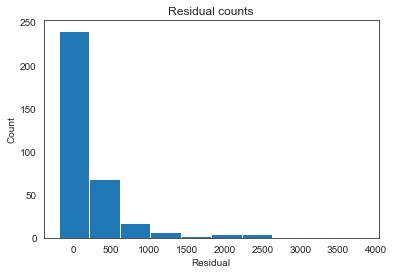

In [8]:
#Plot the sales data again with the square rooted features
X2 = crime_feats[['sqrt_pop', 'sqrt_rob', 'sqrt_mur']]

# Extract predicted values.
predicted2 = regr.predict(X2).ravel()
actual = crime_feats['Propertycrime']

# Calculate the error, also called the residual.
residual2 = actual - predicted2

# This looks a bit concerning.
plt.hist(residual2)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

There's no longer an outlier, but now the residual data is skewed

### Assumption three: homoscedasticity

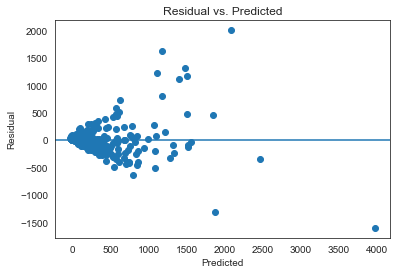

In [9]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

I'm going to transform the dependent variable (property crime)

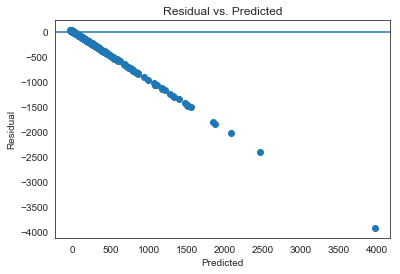

In [10]:
# take the square root of the property crime data then re-plot
prop_crm = crime_feats['Propertycrime']
crime_feats['sqrt_property'] = [math.sqrt(x) for x in  prop_crm]

predicted3 = regr.predict(X).ravel()
actual3 = crime_feats['sqrt_property']

# Calculate the error, also called the residual.
residual3 = actual3 - predicted3

#plot
plt.scatter(predicted3, residual3)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

Now the error terms are distributed homoscedastically.

### Assumption four: low multicollinearity

Check for correlations

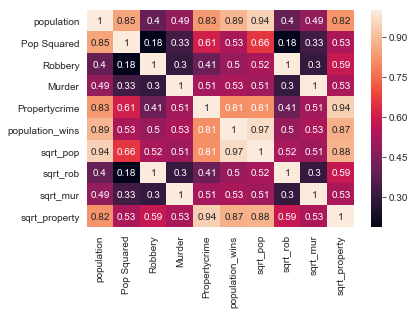

In [11]:
sns.heatmap(crime_feats.corr(), annot=True)
plt.show()

Population has the most correlation with property crime (more than population squared), so I'm going to remove population.

In [12]:
crime_feats.drop(columns=['population'])

,city,Pop Squared,Robbery,Murder,Propertycrime,population_wins,sqrt_pop,sqrt_rob,sqrt_mur,sqrt_property
0,Adams Village,3463321.000,0,0,12.000,1861.000,43.139,0.000,0.000,3.464
1,Addison Town and Village,6640929.000,0,0,24.000,2577.000,50.764,0.000,0.000,4.899
2,Akron Village,8099716.000,0,0,16.000,2846.000,53.348,0.000,0.000,4.000
3,Albany,9595377936.000,1,1,4090.000,49898.000,312.979,1.000,1.000,63.953
4,Albion Village,40806544.000,1,0,223.000,6388.000,79.925,1.000,0.000,14.933
5,Alfred Village,16719921.000,1,0,46.000,4089.000,63.945,1.000,0.000,6.782
6,Allegany Village,3171961.000,0,0,10.000,1781.000,42.202,0.000,0.000,3.162
7,Amherst Town,13993943616.000,1,1,2118.000,49898.000,343.942,1.000,1.000,46.022
8,Amityville Village,90611361.000,1,0,210.000,9519.000,97.565,1.000,0.000,14.491
9,Amsterdam,330585124.000,1,0,405.000,18182.000,134.841,1.000,0.000,20.125
